Для интернет-магазина, работающего, в основном, с аудиторией в Европе. Необходимо измерить эффективность новой onboarding-воронки.
На календаре 1-е ноября 2020 года.

In [1]:
import pandas as pd
import numpy as np
from IPython.core.display import display
from matplotlib import pyplot as plt

import math
from scipy import stats

from datetime import datetime, timedelta

from statsmodels.stats.proportion import proportions_ztest
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize']=(16,5)

import warnings
warnings.filterwarnings('ignore')

/var/folders/25/gqgwspkd05j18m7sk4ftrq7r0000gn/T/ipykernel_17374/1694777440.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


# 1. Подготовка к проведению теста

Мы еще раз все обсудили менеджерами и решили, что тест должен проводиться по вот такому сценарию:
- Тест должен затрагивать только 20% новых юзеров в вашем основном регионе (EU);
- Метрики теста:
    - Конверсия в покупку, ожидается, что она повысится минимум на 25%;
    - Средняя длительность сессии в минутах, ожидается, что она вырастет на 15%.
- Тест должен быть запущен не раньше 1 декабря 2020 года - отдел разработки не успевает все закончить раньше;
- Название теста `new_interface_test`;
- В тесте должны быть две группа:
    - `А` - контрольная, нет изменений; 
    - `B` - тестовая, с новой платежной воронкой. 

In [2]:
# Универсальная функция если понадобится получить имя датафрейма или серии
def get_name(obj):
    name =[x for x in globals() if globals()[x] is obj][0]
    return name

In [3]:
new_users = pd.read_csv('./data/cons_users_history.csv')
sessions = pd.read_csv('./data/cons_sessions_history.csv')
purchases = pd.read_csv('./data/cons_purchases_history.csv')

In [4]:
df_list = [new_users, sessions, purchases]

In [5]:
for df in df_list:
    display(sessions.head(5))
    print(df.info())
    print('-'*60)

,user_id,session_start,session_duration
0,72AC8300FD24B022,2020-09-01 00:29:54,1.887177
1,557FDAFEDC0F995C,2020-09-01 00:23:48,1.969538
2,BE0816B88B7650F2,2020-09-01 11:30:05,2.705548
3,806173CEAC3A1859,2020-09-01 20:15:17,6.164533
4,EDB219D52C071EC8,2020-09-01 21:26:30,5.716415


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144641 entries, 0 to 144640
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   user_id     144641 non-null  object
 1   first_date  144641 non-null  object
 2   region      144641 non-null  object
 3   device      144641 non-null  object
dtypes: object(4)
memory usage: 4.4+ MB
None
------------------------------------------------------------


,user_id,session_start,session_duration
0,72AC8300FD24B022,2020-09-01 00:29:54,1.887177
1,557FDAFEDC0F995C,2020-09-01 00:23:48,1.969538
2,BE0816B88B7650F2,2020-09-01 11:30:05,2.705548
3,806173CEAC3A1859,2020-09-01 20:15:17,6.164533
4,EDB219D52C071EC8,2020-09-01 21:26:30,5.716415


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 663863 entries, 0 to 663862
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           663863 non-null  object 
 1   session_start     663863 non-null  object 
 2   session_duration  663863 non-null  float64
dtypes: float64(1), object(2)
memory usage: 15.2+ MB
None
------------------------------------------------------------


,user_id,session_start,session_duration
0,72AC8300FD24B022,2020-09-01 00:29:54,1.887177
1,557FDAFEDC0F995C,2020-09-01 00:23:48,1.969538
2,BE0816B88B7650F2,2020-09-01 11:30:05,2.705548
3,806173CEAC3A1859,2020-09-01 20:15:17,6.164533
4,EDB219D52C071EC8,2020-09-01 21:26:30,5.716415


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223216 entries, 0 to 223215
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user_id   223216 non-null  object 
 1   event_dt  223216 non-null  object 
 2   revenue   223216 non-null  float64
dtypes: float64(1), object(2)
memory usage: 5.1+ MB
None
------------------------------------------------------------


Выводы:
- пропусков нет;
- даты имеет смысл привести к datetime.

In [6]:
for df in df_list:
    for col in df.columns:
        if 'date' in col or 'start' in col or 'dt' in col:
            df[col] = pd.to_datetime(df[col])

Отбираем только новых пользователей и только из нужного региона. Плюс из календаря маркетинга отбираем только активности для нужного региона.

In [7]:
new_users_eu = new_users.query('region == "EU"')
sessions_eu = sessions.query('user_id in @new_users_eu.user_id')
purchases_eu = purchases.query('user_id in @new_users_eu.user_id')

## 2.1 Определение длительности теста
- Составляем список метрик и для каждой метрики задайте практическую значимость;
- Задаем уровень статистической значимости и требуемую мощность;
- Проводим коррекцию уровня значимости в соотвествии с количеством метрик;
- Расчитывыем необходимую длительность теста для кажой из метрик, выберите общую длительность теста.

In [8]:
metrics = pd.DataFrame([['cr', None, None, 0.25, None, None, None],
                       ['session_duration', None, None, 0.15, None, None, None]],
                       columns=['metrica', 'mean', 'std', 'relative_importance', 'observations', 'observations_per_day', 'duration_test']).set_index('metrica')

In [9]:
metrics

,mean,std,relative_importance,observations,observations_per_day,duration_test
metrica,,,,,,
cr,None,None,0.25,None,None,None
session_duration,None,None,0.15,None,None,None


Заполняем средние и СКО по историческим данным:
- Конверсия в покупку

In [10]:
p = purchases_eu.user_id.nunique() / sessions_eu.user_id.nunique()
metrics.loc[metrics.index == 'cr', ['mean', 'std']] = [p, ((p * (1-p))**.5)]

In [11]:
metrics

,mean,std,relative_importance,observations,observations_per_day,duration_test
metrica,,,,,,
cr,0.459969,0.498395,0.25,None,None,None
session_duration,None,None,0.15,None,None,None


- Средняя длительность сессии

,count,mean,std,min,5%,50%,95%,max
session_duration,280623.0,5.005079,5.013423,0.00002,0.258142,3.472495,15.008576,86.071318


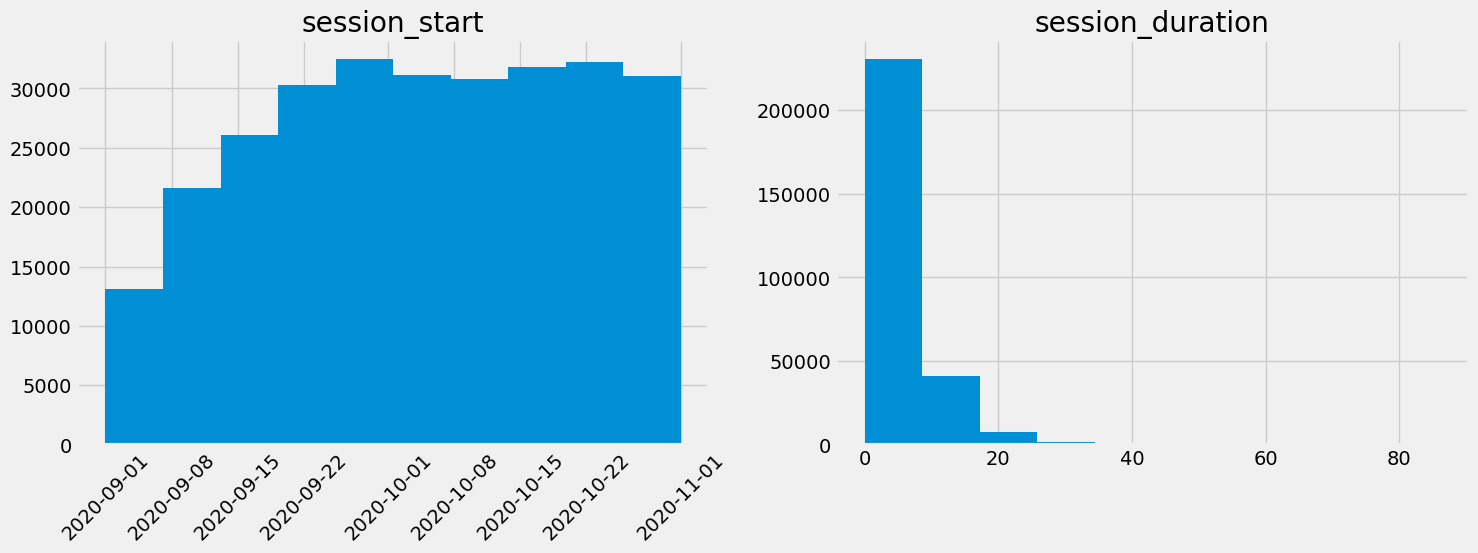

In [12]:
report = sessions_eu.copy()
display(report.describe(percentiles=[.05, .5, .95]).T)

plt.subplots()
report.session_start.hist(ax = plt.subplot(1,2,1)).set_title('session_start')
plt.xticks(rotation=45)
report.session_duration.hist(ax = plt.subplot(1,2,2)).set_title('session_duration')
plt.show()

Выбросы есть, почистим их, а потом почситаем среднее и СКО:

In [13]:
p95 = report.describe(percentiles=[.05, .5, .95]).T['95%']['session_duration']

,count,mean,std,min,5%,50%,95%,max
session_duration,266591.0,4.212322,3.545341,0.00002,0.245247,3.224894,11.643792,15.007481


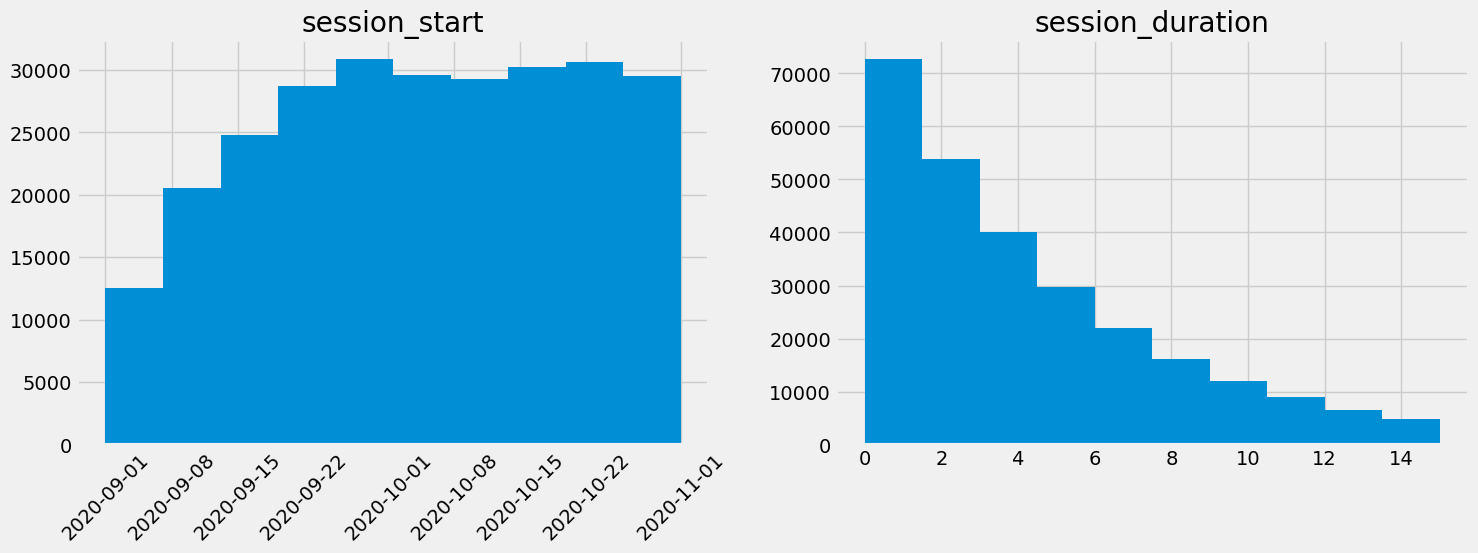

In [14]:
report = report.query('session_duration < @p95')
display(report.describe(percentiles=[.05, .5, .95]).T)

plt.subplots()
report.session_start.hist(ax = plt.subplot(1,2,1)).set_title('session_start')
plt.xticks(rotation=45)
report.session_duration.hist(ax = plt.subplot(1,2,2)).set_title('session_duration')

plt.show()

In [15]:
metrics.loc[metrics.index == 'session_duration', ['mean', 'std']] = [
    report['session_duration'].mean(), 
    report['session_duration'].std()]

In [16]:
metrics

,mean,std,relative_importance,observations,observations_per_day,duration_test
metrica,,,,,,
cr,0.459969,0.498395,0.25,None,None,None
session_duration,4.212322,3.545341,0.15,None,None,None


Задаем уровень значимости и мощность, корректируем уровень значимости. Для уровня значимости и мощности берем дежурные значения, коррекцию проводим методом Бонферрони:

In [17]:
alpha = .05
power = .80
alpha = alpha / metrics.shape[0]
(alpha, power)

(0.025, 0.8)

Расчитываем количество наблюдений:

In [18]:
def get_sample_size(mean, std, relative_importance, alpha, power):
    z = stats.norm.ppf(1 - alpha/2) + abs(stats.norm.ppf(1-power))
    d = mean * relative_importance
    return math.ceil(2 * ((std * z / d) ** 2))

In [19]:
metrics['observations'] = metrics.apply(lambda x: get_sample_size(x['mean'], 
                                                                  x['std'], 
                                                                  x['relative_importance'],alpha, power), axis = 1)
metrics

,mean,std,relative_importance,observations,observations_per_day,duration_test
metrica,,,,,,
cr,0.459969,0.498395,0.25,358,None,None
session_duration,4.212322,3.545341,0.15,599,None,None


Заполняем количество наблюдений в единицу времени (день):
- Для конверсии в покупку наблюдение это каждый новый пользователь;
- Для длительности сессий наблюдение это одна сессия. Т.к. один пользователь сгенерирует как минимум одну сессию, можем считать, что количество наблюдений в день равно как минимум числу новых пользователей в день.

При расчете учитываем, что в тест будут попадать только 20% новых пользователей.

In [20]:
test_audience_mun = 0.2

# конверсия в покупку
mean_daily_users = new_users_eu.groupby('first_date').agg({'user_id':'nunique'})['user_id'].mean()

# средняя длительность сессии
metrics['observations_per_day'] = math.floor(mean_daily_users * test_audience_mun)
metrics

,mean,std,relative_importance,observations,observations_per_day,duration_test
metrica,,,,,,
cr,0.459969,0.498395,0.25,358,241,None
session_duration,4.212322,3.545341,0.15,599,241,None


Расчитаем длительности тестов, учитывая количество групп в тесте:

In [21]:
test_group_num = 2

metrics['duration_test'] = np.ceil(metrics['observations'] / metrics['observations_per_day'] * test_group_num).astype('int')

display(metrics)

test_duration = metrics['duration_test'].max()
print('Рекомендованная длительность теста: {} дня(ей)'.format(test_duration))

,mean,std,relative_importance,observations,observations_per_day,duration_test
metrica,,,,,,
cr,0.459969,0.498395,0.25,358,241,3
session_duration,4.212322,3.545341,0.15,599,241,5


Рекомендованная длительность теста: 5 дня(ей)


In [22]:
metrics['duration_test'].max()
metrics['duration_test'] = metrics['duration_test'].max()
metrics

,mean,std,relative_importance,observations,observations_per_day,duration_test
metrica,,,,,,
cr,0.459969,0.498395,0.25,358,241,5
session_duration,4.212322,3.545341,0.15,599,241,5


Проверим, демонстрируют ли данные сезонность:

In [23]:
sessions_eu['session_date'] = sessions_eu['session_start'].dt.date
new_users_eu['first_date'] = new_users_eu['first_date'].dt.date

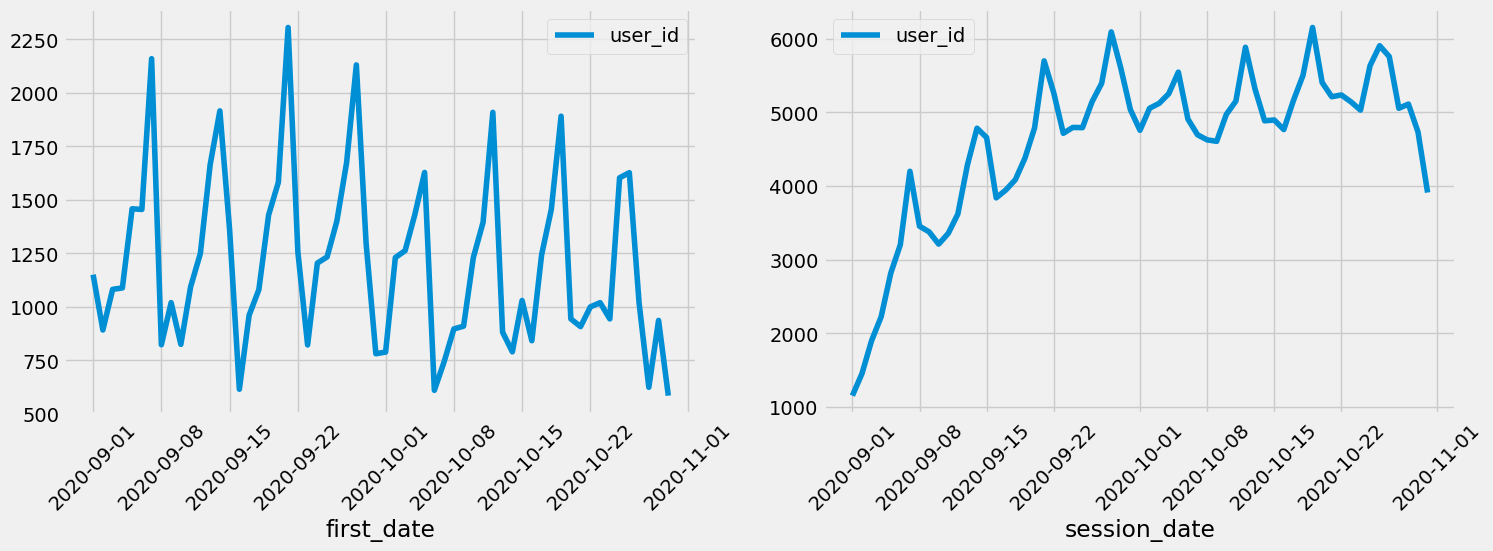

In [24]:
plt.subplots()
new_users_eu.groupby('first_date').agg({'user_id':'nunique'}).plot(ax = plt.subplot(1,2,1))
plt.xticks(rotation=45)
sessions_eu.groupby('session_date').agg({'user_id':'nunique'}).plot(ax = plt.subplot(1,2,2))
plt.xticks(rotation=45)
plt.show()

Вывод: данные демонстрируют явную недельную сезонность. 

Имеет смысл установить длительность теста кратной одной недели. Расчитаем длительность теста с учетом недельной сезонности.

In [25]:
test_duration_adjusted = int(np.ceil(test_duration / 7) * 7)
print('Рекомендованная длительность теста (с учетом недельной сезонности): {} дня(ей)'.format(test_duration_adjusted))

Рекомендованная длительность теста (с учетом недельной сезонности): 7 дня(ей)


Вывод: тест должен быть не короче 7 дней для того, чтобы набрать нужное количество пользователей. 

In [26]:
metrics['duration_test'].max()
metrics['duration_test'] = (np.ceil(metrics['duration_test'].max() / 7) * 7).astype('int')
metrics

,mean,std,relative_importance,observations,observations_per_day,duration_test
metrica,,,,,,
cr,0.459969,0.498395,0.25,358,241,7
session_duration,4.212322,3.545341,0.15,599,241,7


## 1.3 Определение момента запуска и остановки теста

Заказчик просит запустить тест не ранее 01.12, отфильтруем все промки попадающие в интервал времени после начала декабря.

## 1.4 Составление технического задания для разработчиков

Параметры теста:
- Наименование теста: new_interface_test;
- Группы: А (котрольная), B (новая платежная воронка);
- Дата запуска: 2021-01-04
- Дата остановки набора новых пользователей: 2021-01-10;
- Дата остановки: 2021-01-16 (+7 дней активности);
- Аудитория: 20% новых пользователей из региона EU;
- Назначение теста: тестирование изменений, связанных с внедрением улучшенной onboarding-воронки;
- Ожидаемый эфект: конверсия в покупку изменится на 25%, средняя длительность сессии изменится на 15%.

Задаем временные границы теста:

In [27]:
test_start = pd.to_datetime('2021-01-04')
user_acquisition_duration = 7
activity_duration = 1
user_acquisition_end = test_start + timedelta(user_acquisition_duration - 1)

# 2. Проведение теста: ситуация через 5 дней после запуска

После долгих размышлений тест все же решаем запустить 4-го января 2021 года. Представим, что сейчас на календаре 5й день теста - 8-е января 2021. Нам нужно проанализировать промежуточные результаты теста и принять решение о его остановке или продолжении.

## 2.1 Загрузка и подготовка данных

Загружаем данные, преобразуем даты и время:

In [28]:
new_users = pd.read_csv('./data/cons_new_users_monitoring.csv')
sessions = pd.read_csv('./data/cons_sessions_monitoring.csv')
purchases = pd.read_csv('./data/cons_purchases_monitoring.csv')
test_participants = pd.read_csv('./data/cons_participants_monitoring.csv')

new_users['first_date'] = pd.to_datetime(new_users['first_date'])
sessions['session_start'] = pd.to_datetime(sessions['session_start'])
purchases['event_dt'] = pd.to_datetime(purchases['event_dt'])

Посмотрим, как у нас обстоят дела с участниками теста:

In [29]:
test_participants.groupby(['ab_test', 'group']).agg({'user_id': 'nunique'})

user_id
ab_test            group         
another_test       A           33
                   B           32
new_interface_test A          695
                   B          612

In [30]:
test_participants = test_participants.query('ab_test == "new_interface_test"').copy()
test_participants.head()

,user_id,group,ab_test
0,0560881DCDCCB068,B,new_interface_test
1,CD3F1B78180A4F01,A,new_interface_test
2,03096D6895415472,A,new_interface_test
3,A0440113C7188632,A,new_interface_test
4,AA750EC1FEF2FD88,A,new_interface_test


В остальных данных уберем все, что не касается участников теста:

In [31]:
test_new_users = new_users.query('user_id in @test_participants.user_id').merge(test_participants, how='left', on='user_id')
test_sessions = sessions.query('user_id in @test_participants.user_id').merge(test_participants, how='left', on='user_id')
test_purchases= purchases.query('user_id in @test_participants.user_id').merge(test_participants, how='left', on='user_id')

## 2.2 Проверка корректности проведения теста

Посмотрим на состав участников теста по регионам:

In [32]:
report = test_new_users.groupby('region').agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False)
report = report.rename(columns={'user_id':'partycipatns'})
report['%'] = (report['partycipatns'] / report['partycipatns'].sum()).round(4)
report

,partycipatns,%
region,,
EU,1231,0.9419
CIS,44,0.0337
APAC,18,0.0138
N.America,14,0.0107


Основная масса участников была из нужного региона, все ок. Небольшое количество учатников из других регионов можно объяснить перелетами, использованием VPN и т.д.

Проверим, составили ли участники теста нужный % от общего числа новых пользователей в регионе (возьмем только пользователей, пришедших во время теста):

In [33]:
eu_test_users = test_new_users.query('region == "EU"').shape[0]
eu_users = new_users.query('region == "EU" and first_date >= "2021-01-04" and first_date <= "2021-01-16"').shape[0]
eu_test_users / eu_users

0.19980522642428178

Чуть выше уровня, который закладывался в техническом задании. Это нормально. Проведем тест, чтобы проверить действительно ли это статистически значимое различие:
- H0: для пользователя из региона EU вероятность попасть в тест составляет 20%;
- H1: для пользователя из региона EU вероятность попасть в тест отличается от 20%.

Уровень значимости установим 0.05 и откорректируем методом Бонферрони т.к. мы проводим в этой части два теста - текущий и тест на распрееление пользователей по группам.

In [34]:
alpha = .05
alpha = alpha / 2
pvalue = proportions_ztest(eu_test_users, eu_users, value= 0.2)[1]
print(f'p-value {pvalue:.7}')
if pvalue >= alpha: 
    print('Нулевая гипотеза не отвергается: для пользователя из региона EU вероятность попасть в тест составляет 20%.')
else:
    print('Нулевая гипотеза отвергается: для пользователя из региона EU вероятность попасть в тест отличается от 20%.')

p-value 0.9695008
Нулевая гипотеза не отвергается: для пользователя из региона EU вероятность попасть в тест составляет 20%.


Вероятность попасть в группу А составила 53%. Проверим одновыборочным z-тестом:
- H0: вероятность попасть в группу А составляет 50%;
- H1: веростность попасть в группу А отличается от 50%Теперь проверим, была ли вероятность попасть в группы одинаковой:

In [35]:
a_users = test_new_users.query('group == "A"').shape[0]
all_participants = test_participants.shape[0]
a_users / all_participants

0.531752104055088

In [36]:
alpha = .05
alpha = alpha / 2
pvalue = proportions_ztest(a_users, all_participants, value= 0.5)[1]
print(f'p-value {pvalue:.2}')

if pvalue >= alpha: 
    print('Нулевая гипотеза не отвергается: вероятность попасть в группу А составляет 50%')
else:
    print('Нулевая гипотеза отвергается: вероятность попасть в группу А отличается от 50%')

p-value 0.021
Нулевая гипотеза отвергается: вероятность попасть в группу А отличается от 50%


Отлично, значит нам показалось и вероятность попасть в каждую группу равна 50%.

## 2.3 Анализ накопительных метрик и принятие решения об остановке

Установим уровень для необходимого минимального числа участников теста.

In [37]:
metrics

,mean,std,relative_importance,observations,observations_per_day,duration_test
metrica,,,,,,
cr,0.459969,0.498395,0.25,358,241,7
session_duration,4.212322,3.545341,0.15,599,241,7


Для необходимого минимального числа участников теста мы берем потребное количество наблюдений для метрики "Средняя длительность сессии" т.к. именно она влиятет на длительность проведения теста.

In [38]:
required_participants = metrics.loc['session_duration', 'observations'] * test_group_num
required_participants

1198

Кумулятивная динамика:

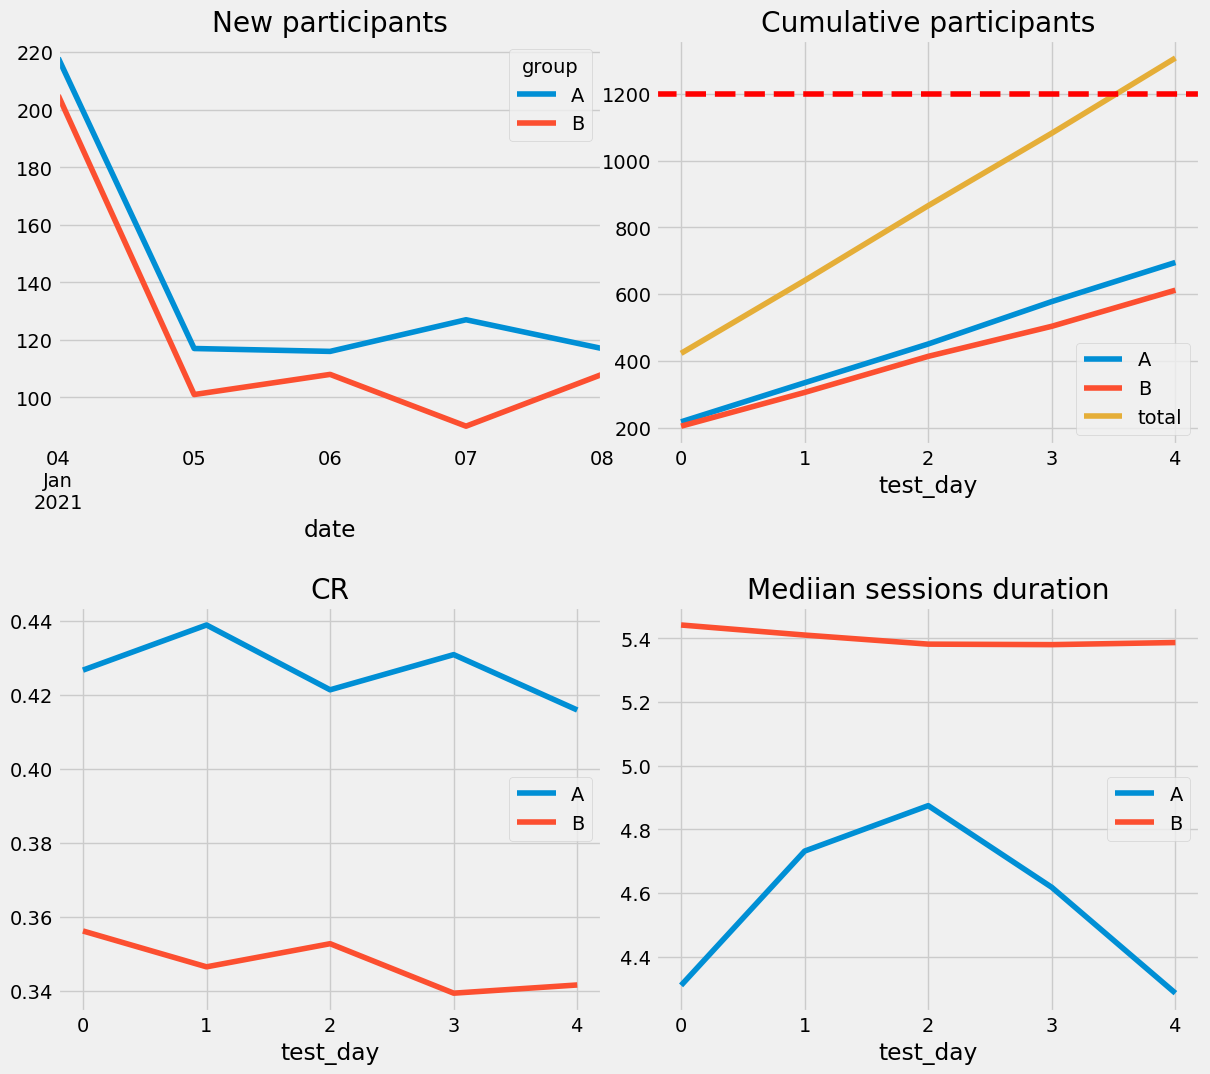

In [39]:
curent_aquistition_duration = 5
test_dates = pd.date_range(start='2021-01-04', periods=curent_aquistition_duration)
test_dates

plt.subplots(figsize=(20,12))

cumulative_test_users = pd.DataFrame(columns=['A', 'B'])
cumulative_test_payers = pd.DataFrame(columns=['A', 'B'])
cumulative_test_sessions = pd.DataFrame(columns=['A', 'B'])

for i, dt in enumerate(test_dates):
    curent_test_users = test_new_users.query('first_date <= @dt').groupby('group').agg({'user_id':'nunique'}).T
    curent_test_users['date'] = dt
    curent_test_users['test_day'] = i
    cumulative_test_users = cumulative_test_users.append(curent_test_users, sort=False)
    
    curent_test_purchases = test_purchases.query('event_dt <= @dt').groupby('user_id').agg({'revenue':'sum'})
    curent_test_payers = (test_new_users.merge(curent_test_purchases, on='user_id', how='inner').
                          query('first_date <= @dt').groupby('group').agg({'user_id':'nunique'}).T)
    curent_test_payers['date'] = dt
    curent_test_payers['test_day'] = i
    cumulative_test_payers = cumulative_test_payers.append(curent_test_payers, sort=False)
    
    curent_test_sessions = test_sessions.query('session_start <= @dt').groupby('group').agg({'session_duration':'median'}).T
    curent_test_sessions['date'] = dt
    curent_test_sessions['test_day'] = i
    cumulative_test_sessions = cumulative_test_sessions.append(curent_test_sessions, sort=False)
    
pd.pivot_table(test_new_users, 
               index='first_date',
               columns='group',
               values='user_id',
               aggfunc='nunique').plot(ax=plt.subplot(2,3,1))
plt.title('New participants')
plt.xlabel('date')
plt.xticks(rotation=0)

# Учачстники
cumulative_test_users = cumulative_test_users.query('date >= "2021-01-04" & date <= "2021-01-16"').set_index('test_day')[['A', 'B']]
cumulative_test_users['total'] = cumulative_test_users['A'] + cumulative_test_users['B']
cumulative_test_users.plot(ax=plt.subplot(2,3,2), xticks=cumulative_test_users.index)
plt.title('Cumulative participants')
plt.axhline(y = required_participants, label = 'Ожидаемое число участников', color = 'red', linestyle = '--')
# plt.xticks(rotation=45)

# Конверсии
cumulative_test_payers = cumulative_test_payers.query('date >= "2021-01-04" & date <= "2021-01-16"').set_index('test_day')[['A', 'B']]
cumulative_test_payers.div(cumulative_test_users)[['A', 'B']].plot(ax=plt.subplot(2,3,4), xticks=cumulative_test_users.index)
plt.title('CR')
# plt.xlabel('day')
# plt.xticks(rotation=45)

# Длительность сессии
cumulative_test_sessions = cumulative_test_sessions.query('date >= "2021-01-04" & date <= "2021-01-16"').set_index('test_day')[['A', 'B']]
cumulative_test_sessions.plot(ax=plt.subplot(2,3,5), xticks=cumulative_test_users.index)
plt.title('Mediian sessions duration')
# plt.xlabel('day')
# plt.xticks(rotation=45)
plt.subplots_adjust(wspace=0.1, hspace=0.4)


plt.show()

Выводы и наблюдения:
- Кумулятивные метрики практически достигли стабильности, но лучше посмотреть еще пару дней;
- Необходимое количество пользователей едва набрано;
- Набор новых пользователей останавливать, тем не менее, не будем т.к. впереди уикенд, который может повлиять на результаты по конверсии;
- Сам тесте останавливать не будет т.к. нам нужно для каждого пользователя получить хотя бы неделю активности после первого захода на сайт.

# 3. Анализ результатов теста

На календаре 17 января 2021 года, тест завершен. Вам нужно проанализировать его результаты.

## 3.1 Подготовка данных

Загружаем данные, преобразуем даты и веремя:

In [40]:
new_users = pd.read_csv('./data/cons_users_test.csv')
sessions = pd.read_csv('./data/cons_sessions_test.csv')
purchases = pd.read_csv('./data/cons_purchases_test.csv')
test_participants = pd.read_csv('./data/cons_participants_test.csv')

new_users['first_date'] = pd.to_datetime(new_users['first_date'])
sessions['session_start'] = pd.to_datetime(sessions['session_start'])
purchases['event_dt'] = pd.to_datetime(purchases['event_dt'])

Посмотрим, как у нас обстоят дела с участниками теста:

In [41]:
test_participants.groupby(['ab_test','group']).agg({'user_id':'nunique'})

user_id
ab_test            group         
another_test       A           43
                   B           47
new_interface_test A         1022
                   B          919

Отфильтруем new_login_screen_apac.

In [42]:
test_participants = test_participants.query('ab_test == "new_interface_test"').copy()
test_participants.head()

,user_id,group,ab_test
0,074B18A93F2F0C72,A,new_interface_test
1,F5B9A6723B88C7A0,A,new_interface_test
2,0560881DCDCCB068,B,new_interface_test
3,1821506A3C8025DF,B,new_interface_test
4,CD3F1B78180A4F01,A,new_interface_test


В остальных данных уберем все, что не касается участников теста:

In [43]:
test_new_users = new_users.query('user_id in @test_participants.user_id').merge(test_participants, on='user_id')
test_sessions = sessions.query('user_id in @test_participants.user_id').merge(test_participants, on='user_id')
test_purchases = purchases.query('user_id in @test_participants.user_id').merge(test_participants, on='user_id')

## 3.2 Анализ накопительных метрик 

Установим уровень для необходимого минимального числа участников теста.

In [44]:
metrics

,mean,std,relative_importance,observations,observations_per_day,duration_test
metrica,,,,,,
cr,0.459969,0.498395,0.25,358,241,7
session_duration,4.212322,3.545341,0.15,599,241,7


In [45]:
required_participants = metrics.loc['session_duration', 'observations'] * test_group_num
required_participants

1198

Кумулятивная динамика:

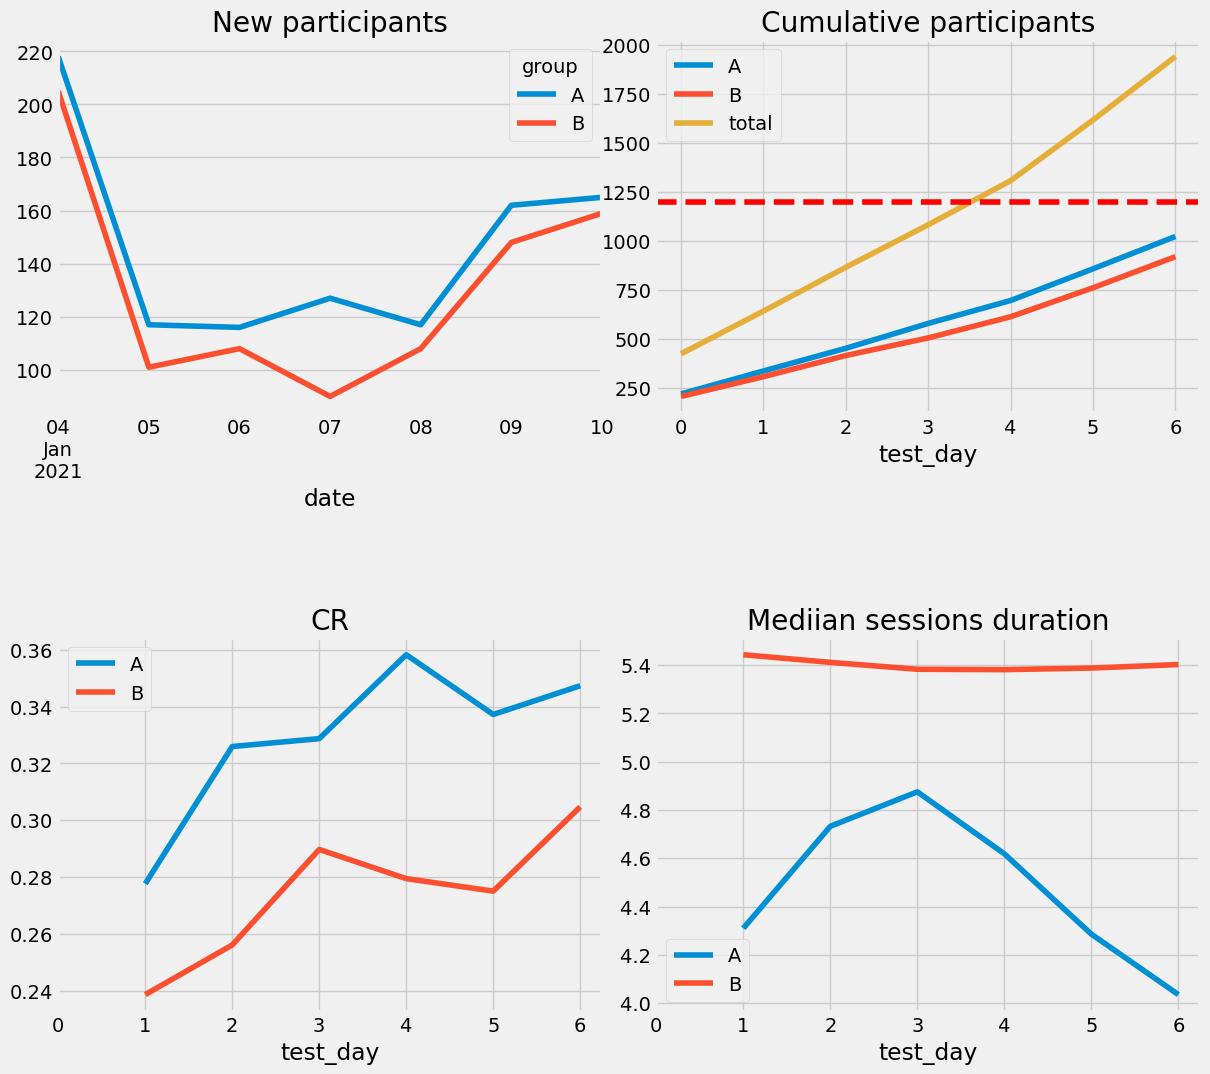

In [46]:
curent_aquistition_duration = 7
test_dates = pd.date_range(start='2021-01-04', periods=curent_aquistition_duration)
test_dates

plt.subplots(figsize=(20,12))

cumulative_test_users = pd.DataFrame(columns=['A', 'B'])
cumulative_test_payers = pd.DataFrame(columns=['A', 'B'])
cumulative_test_sessions = pd.DataFrame(columns=['A', 'B'])

for i, dt in enumerate(test_dates):
    curent_test_users = test_new_users.query('first_date <= @dt').groupby('group').agg({'user_id':'nunique'}).T
    curent_test_users['date'] = dt
    curent_test_users['test_day'] = i
    cumulative_test_users = cumulative_test_users.append(curent_test_users, sort=False)
    
    curent_test_purchases = test_purchases.query('event_dt <= @dt').groupby('user_id').agg({'revenue':'sum'})
    curent_test_payers = (test_new_users.merge(curent_test_purchases, on='user_id', how='inner').
                          query('first_date <= @dt').groupby('group').agg({'user_id':'nunique'}).T)
    curent_test_payers['date'] = dt
    curent_test_payers['test_day'] = i
    cumulative_test_payers = cumulative_test_payers.append(curent_test_payers, sort=False)
    
    curent_test_sessions = test_sessions.query('session_start <= @dt').groupby('group').agg({'session_duration':'median'}).T
    curent_test_sessions['date'] = dt
    curent_test_sessions['test_day'] = i
    cumulative_test_sessions = cumulative_test_sessions.append(curent_test_sessions, sort=False)
    
pd.pivot_table(test_new_users, 
               index='first_date',
               columns='group',
               values='user_id',
               aggfunc='nunique').plot(ax=plt.subplot(2,3,1))
plt.title('New participants')
plt.xlabel('date')
plt.xticks(rotation=0)

# Учачстники
cumulative_test_users = cumulative_test_users.query('date >= "2021-01-04" & date <= "2021-01-16"').set_index('test_day')[['A', 'B']]
cumulative_test_users['total'] = cumulative_test_users['A'] + cumulative_test_users['B']
cumulative_test_users.plot(ax=plt.subplot(2,3,2), xticks=cumulative_test_users.index)
plt.axhline(y = required_participants, label = 'Ожидаемое число участников', color = 'red', linestyle = '--')
plt.title('Cumulative participants')

# Конверсии
cumulative_test_payers = cumulative_test_payers.query('date >= "2021-01-04" & date <= "2021-01-16"').set_index('test_day')[['A', 'B']]
cumulative_test_payers.div(cumulative_test_users)[['A', 'B']].plot(ax=plt.subplot(2,3,4), xticks=cumulative_test_users.index)
plt.title('CR')
# plt.xlabel('day')
# plt.xticks(rotation=45)

# Длительность сессии
cumulative_test_sessions = cumulative_test_sessions.query('date >= "2021-01-04" & date <= "2021-01-16"').set_index('test_day')[['A', 'B']]
cumulative_test_sessions.plot(ax=plt.subplot(2,3,5), xticks=cumulative_test_users.index)
plt.title('Mediian sessions duration')
# plt.xlabel('day')
# plt.xticks(rotation=45)
plt.subplots_adjust(wspace=0.1, hspace=0.6)


plt.show()

Выводы и наблюдения:
- Накопительные метрики достигли относительной стабильности по обеим группам;
- По конверсии, визуально, выиграла группа А;
- По длительности сессии, похоже, выиграла группа В;
- Нужные количества наблюдений достигнуты практически по всем метрикам еще на 5-й день, так что у нас достаточно данных для проведения тестов. 

## 4.3 Проверка гипотез

Будем проводить три теста:
- Процент конвертации в покупку проведем с помощью двухвыборочного z-теста т.к. здесь мы имеем дело с вероятностью конверсии (пропорцией);
- Медианную длительность сессии проверим t-тестом и тестом Манна-Уитни (просто чтобы иметь возможность сравнить результаты).

Поскольку тестов (и гипотез) у нас три, приведем коррекцию уровня значимости методом Бонферрони:

In [47]:
alpha = 0.05
alpha = alpha / 3
alpha

0.016666666666666666

In [48]:
report = test_participants.merge(test_purchases.groupby('user_id').agg({'revenue':'sum'}), how='left', on='user_id')
report['is_buyer'] = (report['revenue'] > 0).astype('int')
report = report.groupby('group').agg({'user_id':'count', 'is_buyer':'sum'}).rename(columns={'user_id':'participants', 'is_buyer':'buyers'})
report['cr'] = report['buyers'] / report['participants']
report

,participants,buyers,cr
group,,,
A,1022,424,0.414873
B,919,346,0.376496


Похоже, что конверсия в группе В сильно ниже. Проверим есть ли отличие с помощью стат-теста:
- H0: Между группами A и B нет различий в % конверсии в покупку;
- H1: Между группами A и B есть различие % конверсии в покупку.

In [49]:
counts = list(report['buyers'].values)
nobs = list(report['participants'].values)

pvalue = proportions_ztest(counts, nobs, value=0)[1]
print(f'p-value = {pvalue:.9f}')
if pvalue >= alpha: 
    print('Нулевая гипотеза не отвергается: между группами A и B нет различий в % конверсии в покупку.')
else:
    print('Нулевая гипотеза отвергается: между группами A и B есть различие % конверсии в покупку.')

p-value = 0.084420399
Нулевая гипотеза не отвергается: между группами A и B нет различий в % конверсии в покупку.


[ссылка на Эвана](https://www.evanmiller.org/ab-testing/chi-squared.html#!424/1022;346/919@95)

Средняя длительность сессии:

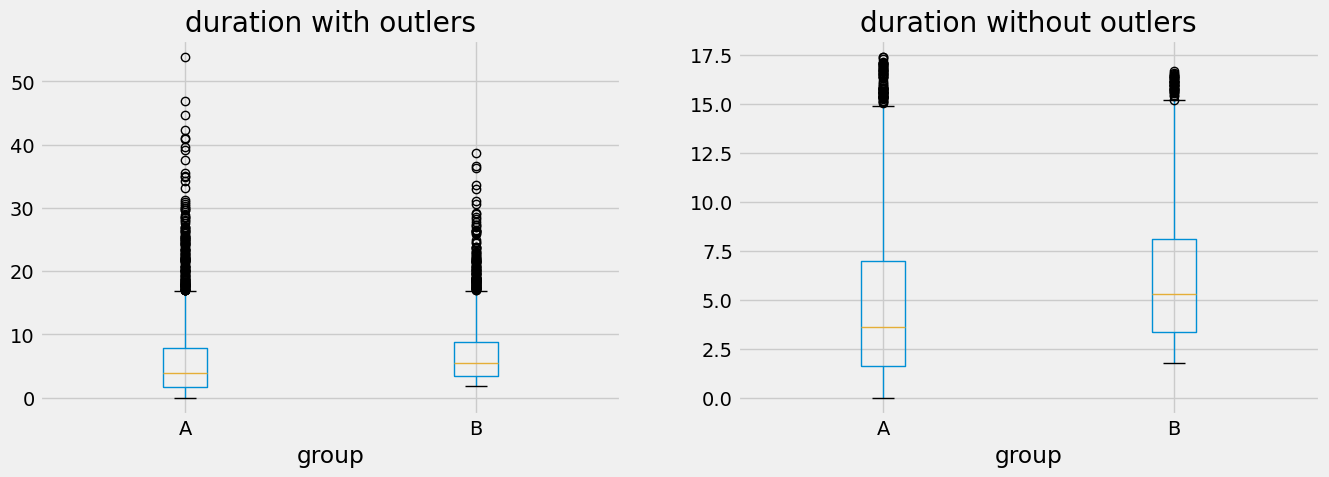

In [50]:
report = test_sessions.copy()

plt.subplots()
report.boxplot('session_duration', by = 'group', ax = plt.subplot(1, 2, 1))
plt.title('duration with outlers')

a_sessions = report.query('group == "A"')[['session_duration', 'group']]
b_sessions = report.query('group == "B"')[['session_duration', 'group']]

#чистим выбросы
a_sessions_ = a_sessions[a_sessions['session_duration'] <= a_sessions['session_duration'].quantile(0.95)]
b_sessions_ = b_sessions[b_sessions['session_duration'] <= b_sessions['session_duration'].quantile(0.95)]
a_sessions_.append(b_sessions_).boxplot('session_duration', by = 'group', ax = plt.subplot(1, 2, 2))
plt.suptitle('')
plt.title('duration without outlers')
plt.show()

Видно, что средняя длительность сессий в группе В заметно подросла. Проверим это t-тестом:
- H0: медианная длительность сессий в группах А и В одинаковая;
- H1: медианная длительность сессий в группах А и В отличается;

In [51]:
pvalue = stats.ttest_ind(a_sessions_['session_duration'].values, b_sessions_['session_duration'].values).pvalue

print('p-value: {}'.format(pvalue))
if pvalue >= alpha: 
    print('Нулевая гипотеза не отвергается: медианная длительность сессий в группах А и В одинаковая.')
else:
    print('Нулевая гипотеза отвергается: медианная длительность сессий в группах А и В отличается.')
    
(b_sessions_['session_duration'].median(), 
 a_sessions_['session_duration'].median(), 
 b_sessions_['session_duration'].median() - a_sessions_['session_duration'].median(), 
 (b_sessions_['session_duration'].median() - 4.21) / 4.21
)

p-value: 8.704016848124417e-33
Нулевая гипотеза отвергается: медианная длительность сессий в группах А и В отличается.


(5.296111205951421, 3.624425962589684, 1.671685243361737, 0.25798365937088386)

Разница между группами составляет примерно 1.6 минуты в пользу группы В.

Продублируем тестом Манна-Уитни, без чистки выбросов:

In [52]:
a_sessions = report.query('group == "A"')[['session_duration', 'group']]
b_sessions = report.query('group == "B"')[['session_duration', 'group']]

pvalue = stats.mannwhitneyu(a_sessions['session_duration'].values, b_sessions['session_duration'].values)[1]

print('p-value: {}'.format(pvalue))
if pvalue >= alpha: 
    print('Нулевая гипотеза не отвергается: форма распределения длительности сессий в группах А и В одинаковая.')
else:
    print('Нулевая гипотеза отвергается: форма распределения длительности сессий в группах А и В отличается.')
     
(b_sessions['session_duration'].median(), 
 a_sessions['session_duration'].median(), 
 b_sessions['session_duration'].median() - a_sessions['session_duration'].median(),
 (b_sessions['session_duration'].mean() - 4.21) / 4.21
)

p-value: 2.298513910588821e-54
Нулевая гипотеза отвергается: форма распределения длительности сессий в группах А и В отличается.


(5.50858544202298, 3.9575410318479314, 1.5510444101750487, 0.6422905918214373)

Можно заключить, что средняя длительность сессии в тестовой группе выросла на 64% по сравнению с базовой длительностью (4.21 минуты).

# Выводы:
1. Тест был проведен в соответствии с ТЗ с небольшими, практически незначимыми отклонениями;
2. Между группами наблюдаются статистически и практически значимое различие в длительности сессий - она выросла на 60% по сравнению с бейзлайном:
3. По конверсии статистически значимых отличий не обнаружилось.
    
Рекомендации для заказчика:
- Новая onboarding-воронка работает не хуже старой, пользователи проводят на сайте больше времени, конверсия не задета. Рекоммендуем внедрять ее на всех пользователей.